In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fetch EUR/USD data
ticker = "EURUSD=X"
data = yf.download(ticker, start="2023-01-01", end="2023-12-31", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [3]:
# remove multiindex 
data.columns = data.columns.droplevel(1) if isinstance(data.columns, pd.MultiIndex) else data.columns
data.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [4]:
def calculate_sma(prices, window):
    """
    Calculate Simple Moving Average (SMA).

    Parameters:
        prices (list or np.ndarray): List of prices.
        window (int): Moving average window size.

    Returns:
        list: SMA values (with None for indices where SMA cannot be calculated).
    """
    # list to store SMA values
    sma = []  
    
    for i in range(len(prices)):
        # Ensure enough data to calc SMA
        if i >= window - 1:
            # Compute SMA as the mean of the last `window` prices
            sma.append(sum(prices[i - window + 1:i + 1]) / window)
        else:
            # Not enough data for SMA, append None
            sma.append(None)
    return sma

In [5]:
def calculate_ema(prices, window):
    """
    Calculate Exponential Moving Average (EMA).

    Parameters:
        prices (list or np.ndarray): List of prices.
        window (int): Moving average window size.

    Returns:
        list: EMA values.
    """
    # list to store EMA values
    ema = []  
    # calc the smoothing factor
    alpha = 2 / (window + 1)  

    # Calc the first EMA value as the SMA of the first `window` prices
    if len(prices) >= window:
        sma = sum(prices[:window]) / window  # Calculate SMA
        ema.append(sma)  # Use SMA as the first EMA value
    else:
        raise ValueError("Not enough data points to calc the initial SMA for EMA.")

    # Calc subsequent EMA values
    for i in range(window, len(prices)):
        ema.append(alpha * prices[i] + (1 - alpha) * ema[-1])
    
    # Add None for the first (window - 1) entries, as EMA is undefined for those
    ema = [None] * (window - 1) + ema

    return ema

In [6]:
def calculate_rolling_std(prices, window):
    """
    Calculate rolling standard deviation.

    Parameters:
        prices (list or np.ndarray): List of prices.
        window (int): Rolling window size.

    Returns:
        list: Rolling standard deviation values (None for periods with insufficient data).
    """
    # List to store stand dev values
    std_values = []  

    for i in range(len(prices)):
        if i >= window - 1:
            # Extract the rolling window of prices
            window_prices = prices[i - window + 1:i + 1]
            # Calculate the mean of the window
            mean = sum(window_prices) / window
            # Calculate the variance
            variance = sum((p - mean) ** 2 for p in window_prices) / window
            # Stand dev is the square root of variance
            std_values.append(variance ** 0.5)
        else:
            # Not enough data to calculate stand dev
            std_values.append(None)
    
    return std_values

In [7]:
def calculate_rsi_smoothed(prices: pd.Series, window: int = 14) -> pd.Series:
    """
    Calculate the Relative Strength Index (RSI) using the smoothed formula.

    Parameters:
        prices (pd.Series): Series of prices.
        window (int): Lookback period for RSI (default is 14).

    Returns:
        pd.Series: RSI values.
    """
    # Calculate daily price changes
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)  # Positive price changes
    loss = -delta.where(delta < 0, 0)  # Absolute value of negative price changes

    # Initialise the first average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Create Series to store RSI values
    rsi = pd.Series(index=prices.index, dtype="float64")

    # Calculate the first RSI value after the initial window
    for i in range(window, len(prices)):
        if i == window:
            # Initial Avg Gain and Avg Loss
            avg_gain.iloc[i] = gain.iloc[:window].mean()
            avg_loss.iloc[i] = loss.iloc[:window].mean()
        else:
            # Smooth Avg Gain and Avg Loss
            avg_gain.iloc[i] = ((avg_gain.iloc[i - 1] * (window - 1)) + gain.iloc[i]) / window
            avg_loss.iloc[i] = ((avg_loss.iloc[i - 1] * (window - 1)) + loss.iloc[i]) / window

        # Compute RSI
        rs = avg_gain.iloc[i] / avg_loss.iloc[i] if avg_loss.iloc[i] != 0 else np.inf
        rsi.iloc[i] = 100 - (100 / (1 + rs))

    return rsi

In [8]:
def calculate_adx(data: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Average Directional Index (ADX) along with +DI and -DI.

    Parameters:
        data (pd.DataFrame): DataFrame with columns 'High', 'Low', 'Close'.
        window (int): Lookback period for ADX.

    Returns:
        pd.DataFrame: Original DataFrame with +DI, -DI, and ADX columns added.
    """
    # Calculate True Range (TR)
    data["TR"] = np.maximum(data["High"] - data["Low"],
                            np.maximum(abs(data["High"] - data["Close"].shift(1)),
                                       abs(data["Low"] - data["Close"].shift(1))))

    # Calculate +DM and -DM
    data["+DM"] = np.where((data["High"] - data["High"].shift(1)) > (data["Low"].shift(1) - data["Low"]),
                           np.maximum(data["High"] - data["High"].shift(1), 0), 0)
    data["-DM"] = np.where((data["Low"].shift(1) - data["Low"]) > (data["High"] - data["High"].shift(1)),
                           np.maximum(data["Low"].shift(1) - data["Low"], 0), 0)

    # Smooth the TR, +DM, and -DM using a moving average
    data["TR_smooth"] = data["TR"].rolling(window=window).mean()
    data["+DM_smooth"] = data["+DM"].rolling(window=window).mean()
    data["-DM_smooth"] = data["-DM"].rolling(window=window).mean()

    # Calculate +DI and -DI
    data["+DI"] = 100 * (data["+DM_smooth"] / data["TR_smooth"])
    data["-DI"] = 100 * (data["-DM_smooth"] / data["TR_smooth"])

    # Calculate DX
    data["DX"] = 100 * abs(data["+DI"] - data["-DI"]) / (data["+DI"] + data["-DI"])

    # Calculate ADX as a rolling average of DX
    data["ADX"] = data["DX"].rolling(window=window).mean()

    return data

In [9]:
# Compute Simple Moving Averages (SMA)
data["SMA_10"] = calculate_sma(prices=data["Close"], window=10)
data["SMA_50"] = calculate_sma(prices=data["Close"], window=50)

# Compute Exponential Moving Averages (EMA)
data["EMA_10"] = calculate_ema(prices=data["Close"], window=10)
data["EMA_50"] = calculate_ema(prices=data["Close"], window=50)

# BB calcs
data["BB_SMA_20"] = calculate_sma(prices=data["Close"], window=20)
data["BB_STD"] = calculate_rolling_std(prices=data["Close"], window=20)
data["UPPER_BB"] = data["BB_SMA_20"] + 2 * data["BB_STD"]
data["LOWER_BB"] = data["BB_SMA_20"] - 2 * data["BB_STD"]

# Calc RSI
data["RSI"] = calculate_rsi_smoothed(prices=data["Close"], window=14)

# Calc MACD
data["EMA_12"] = calculate_ema(prices=data["Close"], window=12)
data["EMA_26"] = calculate_ema(prices=data["Close"], window=26)
data["MACD"] = data["EMA_12"] - data["EMA_26"]
data["MACD_SIGNAL"] = data["MACD"].ewm(span=9, adjust=False).mean() 
data["MACD_HISTO"] = data["MACD"] - data["MACD_SIGNAL"]

# calculate ADX 
data = calculate_adx(data=data, window=14)

C:\Users\barry\AppData\Local\Temp\ipykernel_45632\1513130945.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema.append(alpha * prices[i] + (1 - alpha) * ema[-1])
C:\Users\barry\AppData\Local\Temp\ipykernel_45632\1513130945.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema.append(alpha * prices[i] + (1 - alpha) * ema[-1])
C:\Users\barry\AppData\Local\Temp\ipykernel_45632\1513130945.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

# PLOTS

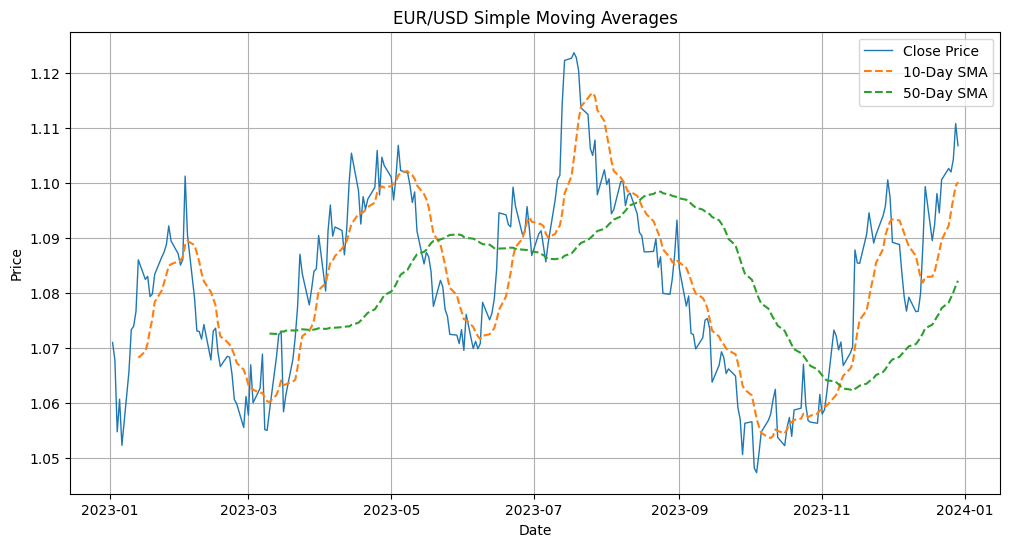

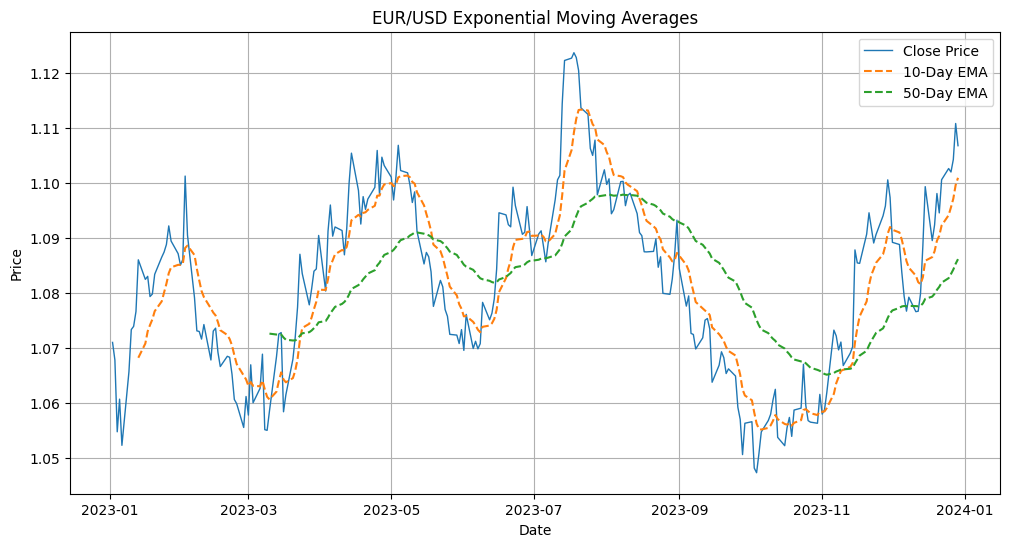

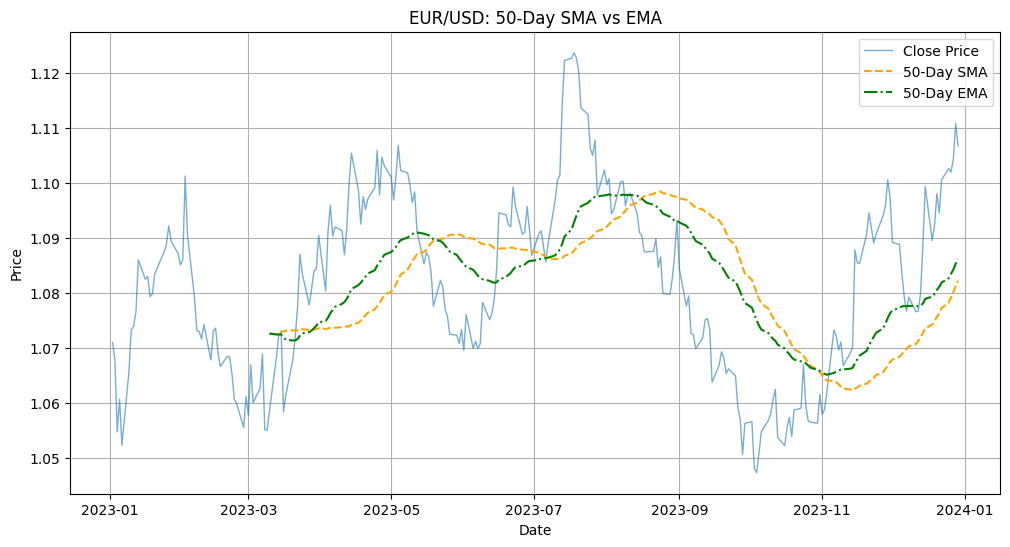

In [10]:
# Plot SMA 
plt.figure(figsize=(12, 6))
plt.plot(data["Close"], label="Close Price", linewidth=1)
plt.plot(data["SMA_10"], label="10-Day SMA", linestyle="--")
plt.plot(data["SMA_50"], label="50-Day SMA", linestyle="--")
plt.title("EUR/USD Simple Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Plot EMA
plt.figure(figsize=(12, 6))
plt.plot(data["Close"], label="Close Price", linewidth=1)
plt.plot(data["EMA_10"], label="10-Day EMA", linestyle="--")
plt.plot(data["EMA_50"], label="50-Day EMA", linestyle="--")
plt.title("EUR/USD Exponential Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# plot EMA and SMA on same chart 
plt.figure(figsize=(12, 6))
plt.plot(data["Close"], label="Close Price", linewidth=1, alpha=0.6)
plt.plot(data["SMA_50"], label="50-Day SMA", linestyle="--", color="orange")
plt.plot(data["EMA_50"], label="50-Day EMA", linestyle="-.", color="green")
plt.title("EUR/USD: 50-Day SMA vs EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

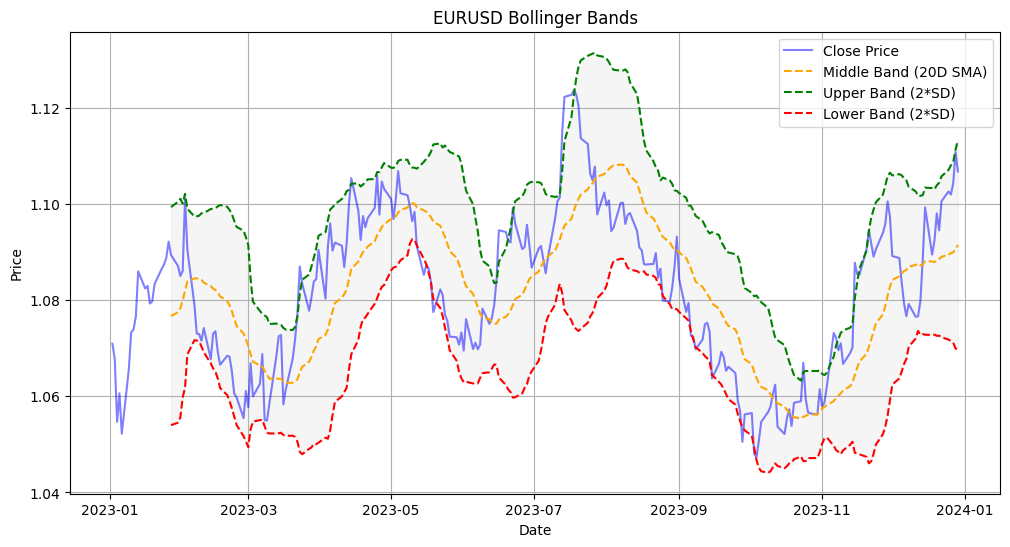

In [11]:
# Plot BBands
plt.figure(figsize=(12, 6))
plt.plot(data["Close"], label="Close Price", color="blue", alpha=0.5)
plt.plot(data["BB_SMA_20"], label="Middle Band (20D SMA)", color="orange", linestyle="--")
plt.plot(data["UPPER_BB"], label="Upper Band (2*SD)", color="green", linestyle="--")
plt.plot(data["LOWER_BB"], label="Lower Band (2*SD)", color="red", linestyle="--")
plt.fill_between(data.index, data["UPPER_BB"], data["LOWER_BB"], color="gray", alpha=0.075)
plt.title("EURUSD Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

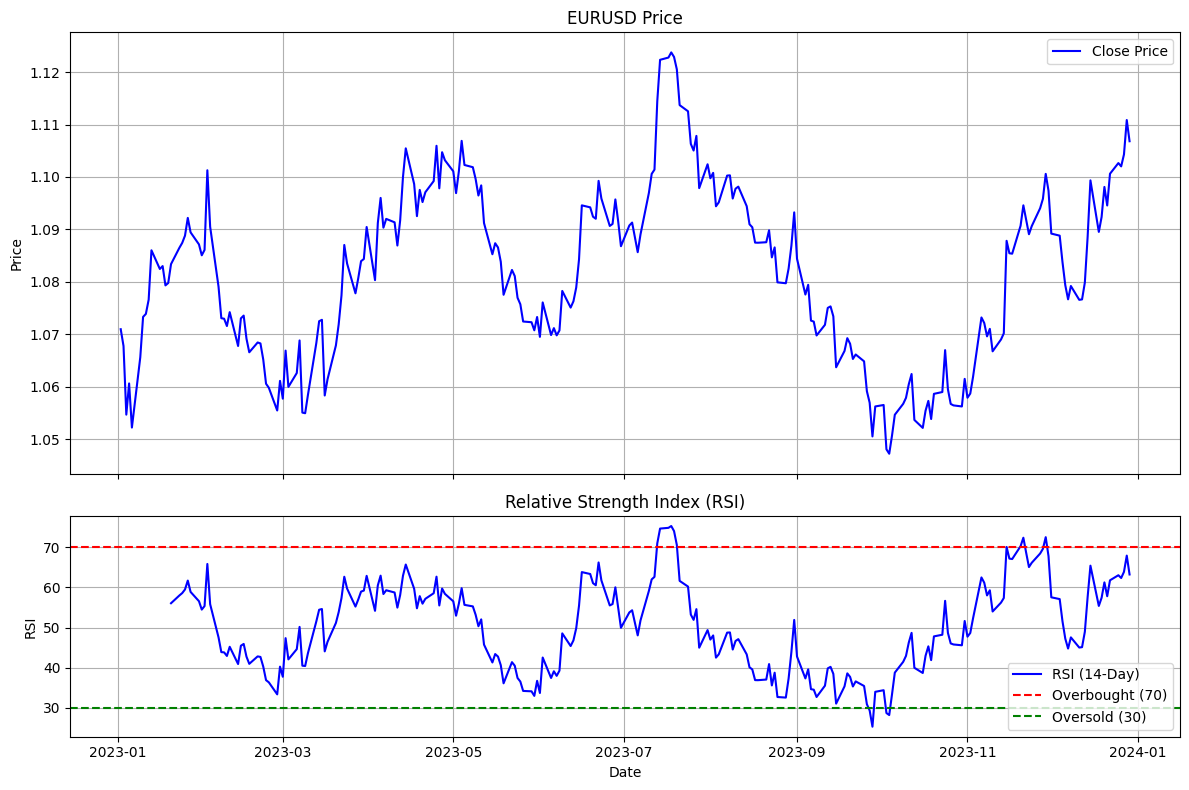

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot asset price 
axes[0].plot(data["Close"], label="Close Price", color="blue", linewidth=1.5)
axes[0].set_title("EURUSD Price")
axes[0].set_ylabel("Price")
axes[0].legend()
axes[0].grid()

# Plot RSI
axes[1].plot(data["RSI"], label="RSI (14-Day)", color="blue")
axes[1].axhline(70, color="red", linestyle="--", label="Overbought (70)")
axes[1].axhline(30, color="green", linestyle="--", label="Oversold (30)")
axes[1].set_title("Relative Strength Index (RSI)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("RSI")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

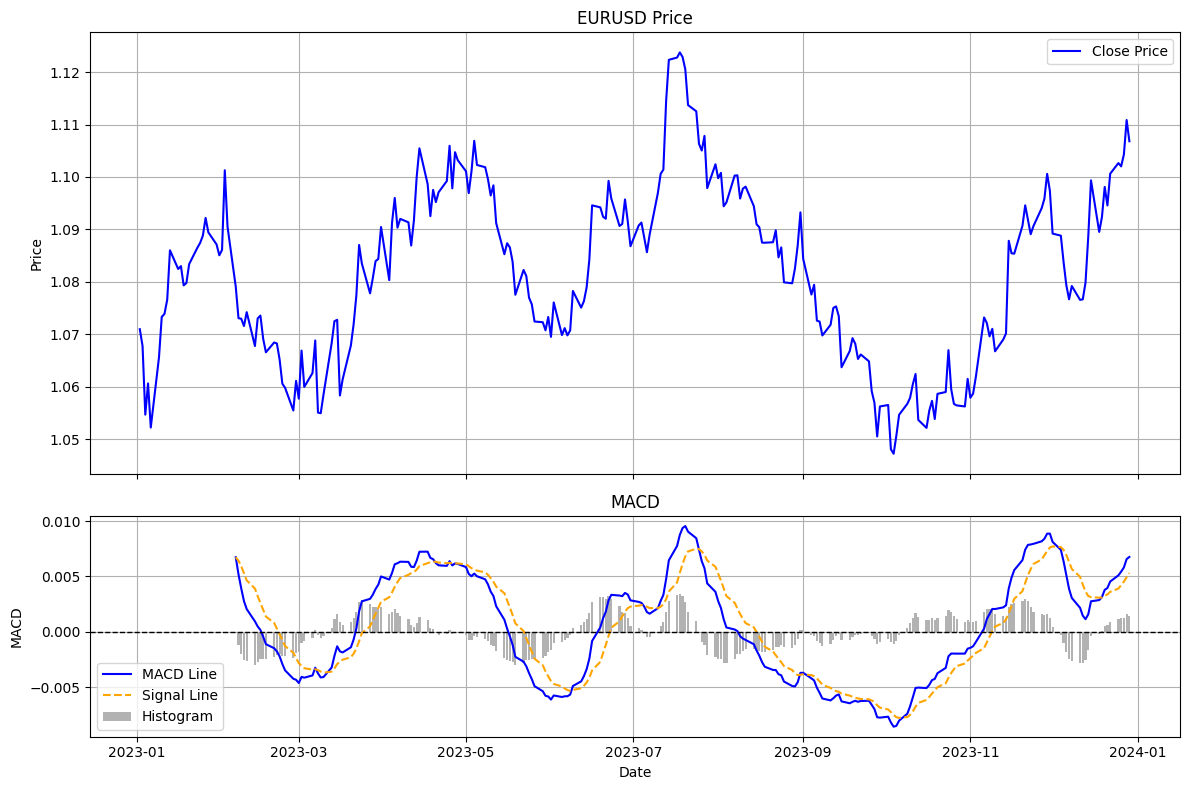

In [13]:
# MACD 
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the price data
axes[0].plot(data["Close"], label="Close Price", color="blue", linewidth=1.5)
axes[0].set_title("EURUSD Price")
axes[0].set_ylabel("Price")
axes[0].legend()
axes[0].grid()

# Plot the MACD
axes[1].plot(data["MACD"], label="MACD Line", color="blue", linewidth=1.5)
axes[1].plot(data["MACD_SIGNAL"], label="Signal Line", color="orange", linestyle="--", linewidth=1.5)
axes[1].bar(data.index, data["MACD_HISTO"], label="Histogram", color="gray", alpha=0.6)
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")
axes[1].set_title("MACD")
axes[1].set_ylabel("MACD")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

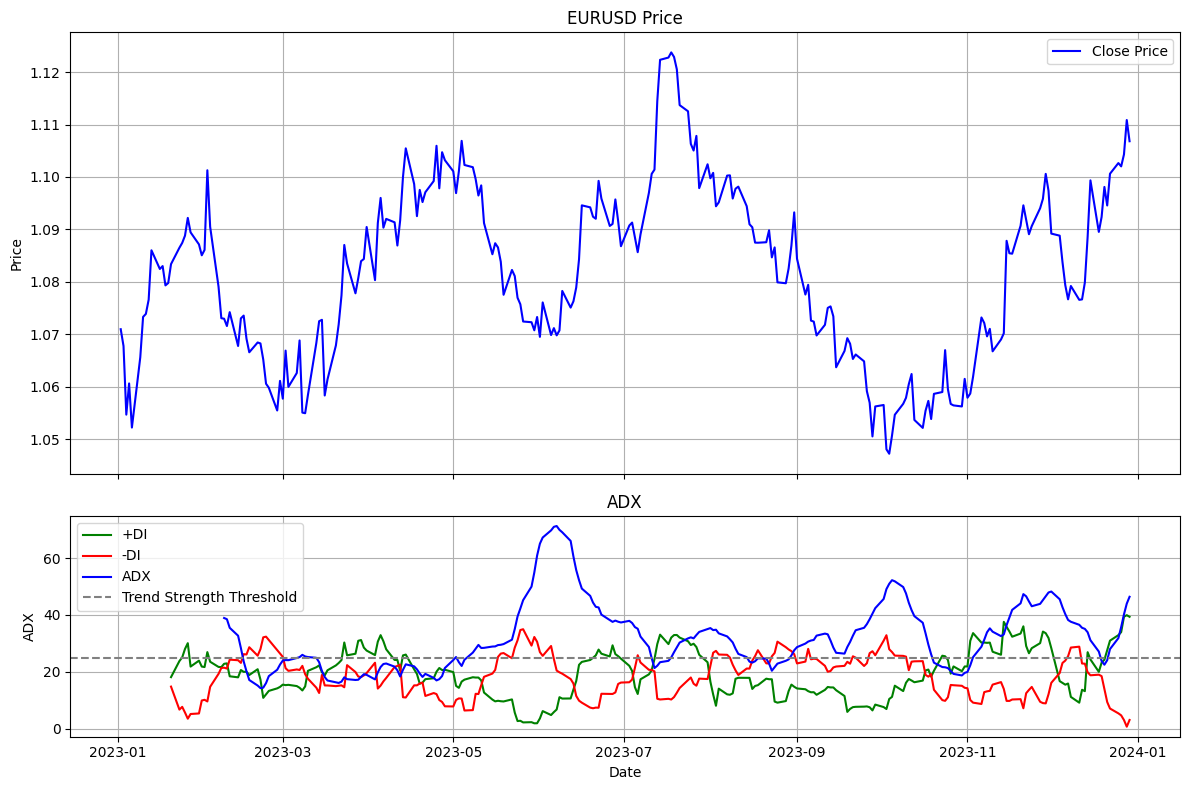

In [14]:
# ADX 
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the price data
axes[0].plot(data["Close"], label="Close Price", color="blue", linewidth=1.5)
axes[0].set_title("EURUSD Price")
axes[0].set_ylabel("Price")
axes[0].legend()
axes[0].grid()

# Plot +DI, -DI, and ADX
axes[1].plot(data["+DI"], label="+DI", color="green")
axes[1].plot(data["-DI"], label="-DI", color="red")
axes[1].plot(data["ADX"], label="ADX", color="blue")
axes[1].axhline(25, color="gray", linestyle="--", label="Trend Strength Threshold")
axes[1].set_title("ADX")
axes[1].set_ylabel("ADX")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()